# Qubit spectroscopy: CZ Ramsey measurement example

Similar to a $T_2^*$ Ramsey experiment, a CZ Ramsey experiment measures fringes resulting from induced Z rotations, which can result in non-unitary CZs. To rectify this non-unitarity, we determine the correction we need to apply to each qubit in the form of `RZ` rotations. If a CZ is perfectly unitary (or has been compensated for adequately with `RZ` pulses), a CZ Ramsey experiment should return 0 radians for each qubit. If, however, some correction is required, these angles will be non-zero. 

A sample QUIL program at one data point (specified by the equatorial Z rotation which maximizes excited state visibility when equal to the required `RZ` correction) between qubits 0 and 1 would look like 

    DECLARE ro BIT[1]
    DECLARE theta REAL[1]
    RX(pi/2) 0
    CZ 0 1
    RZ(theta) 0
    RX(pi/2) 0
    MEASURE 0 ro[0]
    

Setup

In [1]:
from typing import Tuple

from matplotlib import pyplot as plt
import numpy as np

from pyquil import Program
from pyquil.api import get_qc, QuantumComputer
from forest.benchmarking.qubit_spectroscopy import *

In [2]:
#qc = get_qc('Aspen-1-15Q-A')
qc = get_qc('3q-noisy-qvm') # will run on a QVM, but not very meaningfully since there is no cross-talk.
graph = qc.qubit_topology()
edges = list(graph.edges())
edges

[(0, 1), (0, 2), (1, 2)]

In [3]:
# if you are on the QPU you can look at the ISA
# qc.quantum_processor.to_compiler_isa()

## Generate CZ Ramsey experiments

In [4]:
import numpy as np
from numpy import pi
angles = np.linspace(0, 2*pi, 15)
edge = (0, 1)
# generate a set of len(angles) experiments for each measurement qubit on edge (0, 1).
edge_0_1_expts = [generate_cz_phase_ramsey_experiments(edge, measure_q, angles) for measure_q in edge]

## Acquire data
Collect our Ramsey raw data using `estimate_observables`.

In [5]:
from forest.benchmarking.observable_estimation import estimate_observables
# acquire results for each measurement qubit on each edge.
results = []
for angle_expts in zip(*edge_0_1_expts):
    angle_results = []
    for meas_q_expt in angle_expts:
        angle_results += estimate_observables(qc, meas_q_expt, num_shots=500)
    results.append(angle_results)

## Analyze and plot

**Use the results to produce estimates of Ramsey-acquired compensatory RZ phases for this edge**

In the cell below we first extract the expectation and std_err for each measurement and store these results in lists separately for each qubit measured. For each qubit measured we then fit a sinusoid to the data from which we can determine the `offset` of the maximum excited state visibility, which tells us the effective imparted phase. Finally we plot the CZ Ramsey fringes for each qubit with respect to increasing applied contrast phase.

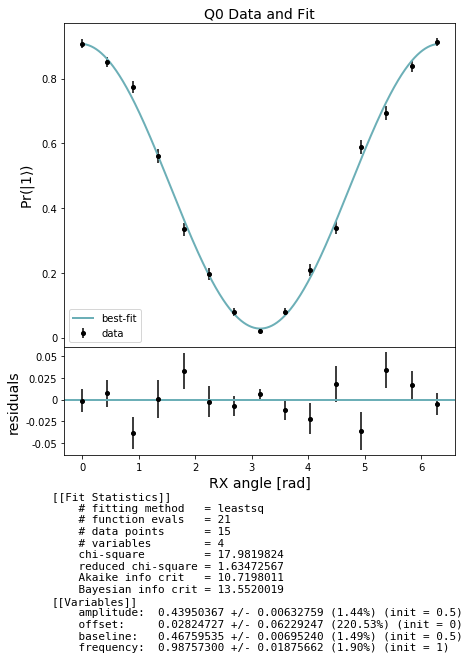

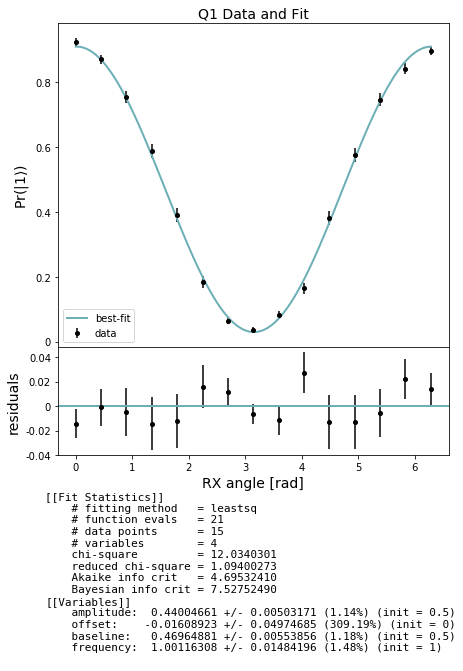

In [6]:
from forest.benchmarking.plotting import plot_figure_for_fit

stats_by_qubit = get_stats_by_qubit(results)
for q, stats in stats_by_qubit.items():
    fit = fit_cz_phase_ramsey_results(angles, stats['expectation'], stats['std_err'])
    fig, axs = plot_figure_for_fit(fit, title=f'Q{q} Data and Fit', xlabel="RX angle [rad]",
                           ylabel=r"Pr($|1\rangle$)")
    frequency = fit.params['frequency'].value # ratio of actual angle over intended control angle
    amplitude = fit.params['amplitude'].value # (P(1 given 1) - P(1 given 0)) / 2
    baseline = fit.params['baseline'].value # amplitude + P(1 given 0)
    offset = fit.params['offset'].value # effective imparted phase on the qubit from the CZ, relative to the true qubit frequency